# Train A Shape Classifier Model



In [4]:
import json
import os

train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (including resizing and normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (black and white images)
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_data_root, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names (optional)
print(f'Classes: {train_dataset.classes}')

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: circle, triangle, rectangle
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # First Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = F.relu(self.conv2(x))   # Second Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))     # Fully Connected Layer 1
        x = self.fc2(x)             # Fully Connected Layer 2 (output)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}')


Classes: ['circle', 'diamond', 'triangle']


# Train

In [12]:
train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Loss: 1.1029, Accuracy: 0.35
Epoch [2/15], Loss: 1.0133, Accuracy: 0.47
Epoch [3/15], Loss: 0.8998, Accuracy: 0.57
Epoch [4/15], Loss: 0.7890, Accuracy: 0.66
Epoch [5/15], Loss: 0.5825, Accuracy: 0.80
Epoch [6/15], Loss: 0.3724, Accuracy: 0.86
Epoch [7/15], Loss: 0.2382, Accuracy: 0.92
Epoch [8/15], Loss: 0.1554, Accuracy: 0.95
Epoch [9/15], Loss: 0.0968, Accuracy: 0.97
Epoch [10/15], Loss: 0.0688, Accuracy: 0.99
Epoch [11/15], Loss: 0.0459, Accuracy: 0.99
Epoch [12/15], Loss: 0.0304, Accuracy: 1.00
Epoch [13/15], Loss: 0.0148, Accuracy: 1.00
Epoch [14/15], Loss: 0.0091, Accuracy: 1.00
Epoch [15/15], Loss: 0.0064, Accuracy: 1.00


# Test 

In [20]:
def test(model, test_loader):
    """Print the Precision, Recall and F1-score for the trained model
    """
    model.eval()
    correct = 0
    total = 0
    
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
    accuracy = correct / total
        
    print(f"Test Acuracy: {accuracy:.2f}")
    



test(model, test_loader)


Test Acuracy: 0.78


# Show Predictions


TypeError: only integer tensors of a single element can be converted to an index

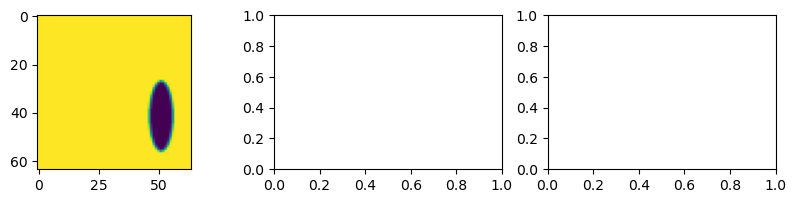

In [31]:
import matplotlib.pyplot as plt 
import numpy as np

def show_prediction(model, image):
    """Pass the image to the model and overlay the predicted shape and confidence on the input
    image and display it
    """
    
    
    model.eval()
    
    
    image, label = next(iter(test_loader))
    image, label = image.to(device), label.to(device)
    
    
    #model prediction 
    
    with torch.no_grad():
        output = model.forward(image)
        _, predicted = torch.max(output, 1)
        
        
        
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,2))
    for i in range(3):
        
        img = image[i].cpu().numpy().squeeze()
        axes[i].imshow(img)
        
        axes[i].set_title(f"Predicted:{train_dataset.classes[predicted]}\nActual:{train_dataset.classes[i]}")
        axes[i].axis('off')
    
    plt.show()
    
show_prediction(model, test_loader)